In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
import ternary
import copy

In [2]:
# os 
# json
import os
import json
import pandas as pd
class read_inputjson_edge_single_calculation:
# group the elements from reading the input file
    def __init__(self,fh):
        if os.path.isfile(fh):
            self.file = fh
            self.data = json.load(open(fh))
            self.model = self.data["model"]
            self.name = self.data["material"]
        else:
            print('input file not in current directory')
            quit()

    def check_integrity_curtin_edge(self):
        def common_elements(list_1, list_2):
            a_set = set(list_1)
            b_set = set(list_2)
            if (a_set & b_set):
                return True
            else:
                return False
        def check_input_data(element_list,element_data):
            for element in element_list:
                if not element_data[element]:
                    print('No data found: {}'.format(element))
                
    def grab_properties_curtin_edge(self):

        
        self.element_data = self.data['elements']
        
        self.elements_order = self.data['compositions']['element_order']
            
        self.concentrations = np.array(self.data['compositions']['concentrations'])
        
        try:
            self.temperature = np.arange(self.data['conditions']['temperature']['min'],
                                        self.data['conditions']['temperature']['max']+self.data['conditions']['temperature']['inc'],
                                        self.data['conditions']['temperature']['inc'])
        except:
            self.temperature = np.array([float(self.data['conditions']['temperature'])])
            
        element_composition = {}
        for i in range(len(self.elements_order)):
            element_composition[self.elements_order[i]] = self.concentrations.T[i]
        self.element_composition = pd.DataFrame(data=element_composition)
        self.strain_r = self.data['conditions']['strain_r']
        self.exp_conditions = [self.temperature,self.strain_r]
        self.structure = (self.data["structure"].lower())
        self.model = self.data['model']['name']
        if self.model in ['FCC_Varvenne-Curtin-2016','BCC_edge_Maresca-Curtin-2019']:
            if 'f1' in self.data['model']['name']:
                self.f1 = self.data['model']['name']['f1']
            else:
                if self.structure == 'fcc':
                    self.f1 = 0.35
                else: 
                    self.f1 = 0.7844
            if 'f2' in self.data['model']['name']:
                self.f2 = self.data['model']['name']['f2']
            else:
                if self.structure == 'fcc':
                    self.f2 = 5.7
                else: 
                    self.f2 = 7.2993
                
            if 'alpha' in self.data['model']['name']:
                self.alpha = self.data['model']['name']['alpha']
            else:
                self.alpha = 0.123
        self.adjustable_scaler= [self.alpha,self.f1,self.f2]
        for element_i in self.elements_order:
            # compute E, nu, G for elements if not supplied
            # two of the E/nu/G must be supplied to calculate the missing one
            if not 'nu' in self.element_data[element_i]: 
                self.element_data[element_i]['nu'] = round(self.element_data[element_i]['E']/2/self.element_data[element_i]['G'] - 1,3)
            if not 'G' in self.element_data[element_i]:
                self.element_data[element_i]['G'] = round(self.element_data[element_i]['E']/2/(self.element_data[element_i]['nu'] + 1),1)
            if not 'E' in self.element_data[element_i]:
                self.element_data[element_i]['E'] = round(self.element_data[element_i]['G']*2*(self.element_data[element_i]['nu'] + 1),1)
            
            # compute a/b/Vn for elements based on lattice structure
            # one of the a/b/Vn must be supplied to compute the other two
            if self.structure == 'fcc':
                # fcc: Vn = a^3/4, b = a/sqrt(2)
                if 'Vn' in self.element_data[element_i]:
                    self.element_data[element_i]['a'] = (self.element_data[element_i]['Vn']*4)**(1/3)
                    self.element_data[element_i]['b'] = self.element_data[element_i]['a']/np.sqrt(2)
                elif 'b' in self.element_data[element_i]:
                    self.element_data[element_i]['a'] = self.element_data[element_i]['b']*np.sqrt(2)
                    self.element_data[element_i]['Vn'] = self.element_data[element_i]['a']**3/4
                elif 'a' in self.element_data[element_i]:
                    self.element_data[element_i]['b'] = self.element_data[element_i]['a']/np.sqrt(2)
                    self.element_data[element_i]['Vn'] = self.element_data[element_i]['a']**3/4
            else: 
                # bcc: Vn = a^3/2, b = a*sqrt(3)/2
                if 'Vn' in self.element_data[element_i]:
                    self.element_data[element_i]['a'] = (self.element_data[element_i]['Vn']*2)**(1/3)
                    self.element_data[element_i]['b'] = self.element_data[element_i]['a']*np.sqrt(3)/2
                elif 'b' in self.element_data[element_i]:
                    self.element_data[element_i]['a'] = self.element_data[element_i]['b']*2/np.sqrt(3)
                    self.element_data[element_i]['Vn'] = self.element_data[element_i]['a']**3/2
                elif 'a' in self.element_data[element_i]:
                    self.element_data[element_i]['b'] = self.element_data[element_i]['a']*np.sqrt(3)/2
                    self.element_data[element_i]['Vn'] = self.element_data[element_i]['a']**3/2
                    
        if "uncertainty_level" in self.data:
            #'a': uncertainty of lattice constant, if on, default is 1% 
            #'elastic constant': uncertainty of lattice constants, if on, default is 5% for each element
            
            if self.data["uncertainty_level"]["on/off"].lower() == "on":
                if "a" in self.data["uncertainty_level"]:
                    self.uncertainty_a = self.data["uncertainty_level"]['a']
                else: 
                    self.uncertainty_a = 0.01
                if "elastic_constants" in self.data["uncertainty_level"]:
                    self.uncertainty_EGv = self.data["uncertainty_level"]['elastic_constants']
                else: 
                    self.uncertainty_EGv = 0.05
            else: 
                self.uncertainty_a = 0
                self.uncertainty_EGv = 0
        self.uncertainty_levels = [self.uncertainty_a,self.uncertainty_EGv]
    

In [3]:
input_data = read_inputjson_edge_single_calculation('../sample_input_FCC_single_compositions.json')

In [4]:
input_data.check_integrity_curtin_edge()
input_data.grab_properties_curtin_edge()
input_data.element_composition

,Co,Ni,Fe,Mn
0,25,25,25,25
1,20,20,30,30
2,30,30,20,20


In [5]:
for i in range(len(input_data.element_composition)):
    comp = input_data.element_composition.iloc[i]
    print(dict(zip(input_data.element_composition.columns.to_list(),comp.values)))

{'Co': 25, 'Ni': 25, 'Fe': 25, 'Mn': 25}
{'Co': 20, 'Ni': 20, 'Fe': 30, 'Mn': 30}
{'Co': 30, 'Ni': 30, 'Fe': 20, 'Mn': 20}


In [6]:
'''model = ss_edge_model(input_data.adjustable_scaler,
                      input_data.exp_conditions,
                      comp_elements,
                      input_data.element_data,
                      input_data.structure)'''

'model = ss_edge_model(input_data.adjustable_scaler,\n                      input_data.exp_conditions,\n                      comp_elements,\n                      input_data.element_data,\n                      input_data.structure)'

In [7]:
class ss_edge_model_T:
# calculate solid solution strengthening contribution for FCC/BCC CCAs
# Edge dislocation models
# FCC model: Varvenne-Leyson-Ghazisaeidi-Curtin 2016: http://dx.doi.org/10.1016/j.actamat.2016.09.046
# BCC model: Maresca-Curtin 2020: https://doi.org/10.1016/j.actamat.2019.10.015
# for simeple calculations 
    def __init__(self,
                 adjustable_scaler,
                 exp_conditions,
                 comp_elements,
                 elements_data,
                 structure):
        
        # dislocation properties, alpha, f1, and f2
        self.alpha = float(adjustable_scaler[0])
        self.f_tau = float(adjustable_scaler[1])
        self.f_dEb = float(adjustable_scaler[2])
        
        # experiment conditions, T, strain rate
        self.T_range = np.array(exp_conditions[0])
        self.ep = float(exp_conditions[1])
        self.ep0 = 10**4 #reference strain rate (/s)
        
        # some constants 
        self.boltzmann_J = 1.38064852*10**(-23) #J/K
        self.J2eV=6.2415093433*10**18 # covert J to eV
        
        # elemental data
        self.elements_order = comp_elements.columns.tolist()
        self.compositions_all = comp_elements #pandas df
        self.elements_data = copy.deepcopy(elements_data) #json
        
        # convert unit for properties
        # Vn: Å^3 to m^3
        # b: Å to m
        # a: Å to m
        # E: GPa to Pa
        # G: GPa to Pa
        
        for element_i in self.elements_order:
            self.elements_data[element_i]['Vn'] = elements_data[element_i]['Vn']*10**(-30)
            self.elements_data[element_i]['b'] = elements_data[element_i]['b']*10**(-10)
            self.elements_data[element_i]['a'] = elements_data[element_i]['a']*10**(-10)
            self.elements_data[element_i]['E'] = elements_data[element_i]['E']*10**(9)
            self.elements_data[element_i]['G'] = elements_data[element_i]['G']*10**(9)

        
        
        self.structure = structure
    
    def change_element_data(self,elements_data):
        self.elements_data = elements_data
        for element_i in self.elements_order:
            self.elements_data[element_i]['Vn'] = elements_data[element_i]['Vn']*10**(-30)
            self.elements_data[element_i]['b'] = elements_data[element_i]['b']*10**(-10)
            self.elements_data[element_i]['a'] = elements_data[element_i]['a']*10**(-10)
            self.elements_data[element_i]['E'] = elements_data[element_i]['E']*10**(9)
            self.elements_data[element_i]['G'] = elements_data[element_i]['G']*10**(9)


    def FCC_V_L_G_C_2016_analytical(self):
        # FCC model: Varvenne-Leyson-Ghazisaeidi-Curtin 2016: http://dx.doi.org/10.1016/j.actamat.2016.09.046
        
        self.prefac_ty0 = 0.051
        self.Taylor_fac = 3.06
        self.prefac_dEb = 0.274
        # averaged properties
        cn_Vn = []
        cn_nu = []
        cn_G = []
        cn_b = []
        cn_E = []
        for element_i in self.elements_order:
            cn_Vn.append(self.compositions[element_i]/100*self.elements_data[element_i]['Vn'])
            cn_nu.append(self.compositions[element_i]/100*self.elements_data[element_i]['nu'])
            cn_G.append(self.compositions[element_i]/100*self.elements_data[element_i]['G'])
            cn_b.append(self.compositions[element_i]/100*self.elements_data[element_i]['b'])
            cn_E.append(self.compositions[element_i]/100*self.elements_data[element_i]['E'])

        self.aver_E = sum(cn_E);
        self.aver_V = sum(cn_Vn);
        self.aver_G = sum(cn_G)
        self.aver_Nu = sum(cn_nu)
        self.aver_b = sum(cn_b)
        
        i = 0;cn_Delta_Vn2=[]
        for element_i in self.elements_order:
            cn_Delta_Vn2.append(self.compositions[element_i]/100*(self.elements_data[element_i]['Vn']-self.aver_V)**2)
            
        self.sum_cndVn_b6 = sum(cn_Delta_Vn2)/self.aver_b**6;
        q_nu = ((1 + self.aver_Nu)/(1 - self.aver_Nu))
        
        self.dEb = self.prefac_dEb * self.f_dEb * self.alpha**(1/3)  * self.aver_G * self.aver_b**3   * q_nu**(2/3) * self.sum_cndVn_b6**(1/3)
        self.Ty0 = self.prefac_ty0 * self.f_tau * self.alpha**(-1/3) * self.aver_G * q_nu**(4/3) * self.sum_cndVn_b6**(2/3)
        self.Ty0_pc = self.Taylor_fac * self.Ty0
        delta_ss_low_T = self.Ty0 * (1 - ((self.boltzmann_J*self.T)/(self.dEb) * np.log(self.ep0/self.ep))**(2/3) )
        delta_ss_high_T = self.Ty0 * np.exp(-1/0.55 * self.boltzmann_J*self.T/self.dEb * np.log(self.ep0/self.ep) )
        self.delta_ss_low_T = delta_ss_low_T
        self.delta_ss_high_T = delta_ss_high_T
        Ty_threshold = self.Ty0/2
        
        self.delta_ss = self.Taylor_fac*np.array(delta_ss_low_T if delta_ss_low_T>=Ty_threshold else delta_ss_high_T)
        
        
    def BCC_M_C_2020_analytical(self):
        # BCC model: Maresca-Curtin-2019: https://doi.org/10.1016/j.actamat.2019.10.015
        
        self.prefac_ty0 = 0.051
        self.Taylor_fac = 3.06
        self.prefac_dEb = 0.274
        # averaged properties
        cn_Vn = []
        cn_nu = []
        cn_G = []
        cn_b = []
        cn_E = []
        for element_i in self.elements_order:
            cn_Vn.append(self.compositions[element_i]/100*self.elements_data[element_i]['Vn'])
            cn_nu.append(self.compositions[element_i]/100*self.elements_data[element_i]['nu'])
            cn_G.append(self.compositions[element_i]/100*self.elements_data[element_i]['G'])
            cn_b.append(self.compositions[element_i]/100*self.elements_data[element_i]['b'])
            cn_E.append(self.compositions[element_i]/100*self.elements_data[element_i]['E'])

        self.aver_E = sum(cn_E);
        self.aver_V = sum(cn_Vn);
        self.aver_G = sum(cn_G)
        self.aver_Nu = sum(cn_nu)
        self.aver_b = sum(cn_b)
        
        i = 0;cn_Delta_Vn2=[]
        for element_i in self.elements_order:
            cn_Delta_Vn2.append(self.compositions[element_i]/100*(self.elements_data[element_i]['Vn']-self.aver_V)**2)
            
        self.sum_cndVn_b6 = sum(cn_Delta_Vn2)/self.aver_b**6;
        q_nu = ((1 + self.aver_Nu)/(1 - self.aver_Nu))
        
        self.dEb = self.prefac_dEb * self.f_dEb * self.alpha**(1/3)  * self.aver_G * self.aver_b**3   * q_nu**(2/3) * self.sum_cndVn_b6**(1/3)
        self.Ty0 = self.prefac_ty0 * self.f_tau * self.alpha**(-1/3) * self.aver_G * q_nu**(4/3) * self.sum_cndVn_b6**(2/3)
        self.Ty0_pc = self.Taylor_fac * self.Ty0
        delta_ss_low_T = self.Ty0 * (1 - ((self.boltzmann_J*self.T)/(self.dEb) * np.log(self.ep0/self.ep))**(2/3) )
        delta_ss_high_T = self.Ty0 * np.exp(-1/0.55 * self.boltzmann_J*self.T/self.dEb * np.log(self.ep0/self.ep) )
        Ty_threshold = self.Ty0/2
        self.delta_ss_low_T = delta_ss_low_T
        self.delta_ss_high_T = delta_ss_high_T
        self.delta_ss = self.Taylor_fac*np.array(delta_ss_low_T if delta_ss_low_T>=Ty_threshold else delta_ss_high_T)
        
    def calculate(self):
        calc_header = ['T','V_ave','b_ave','E_ave','G_ave','nu_ave','sum_cnVn^2_b6','Ty0','Delta_Eb','tau_y','Delta_sigma_ss']
        element_header = self.compositions_all.columns.to_list()
        calc_data_all = pd.DataFrame(columns=element_header+calc_header)
        for composition_idx in range(len(self.compositions_all)):
            self.compositions = self.compositions_all.iloc[composition_idx]
           # print(self.compositions)
            for T in self.T_range:
                self.T = T
                #print(T)
                if self.structure == 'fcc':
                    self.FCC_V_L_G_C_2016_analytical()
                elif self.structure == 'bcc':
                    self.BCC_M_C_2020_analytical()
                
                calc_values = [self.T,
                               np.round(self.aver_V*10**30,2),
                               np.round(self.aver_b*10**10,4),
                               np.round( self.aver_E/10**9,2),
                               np.round( self.aver_G/10**9,2),
                               np.round( self.aver_Nu,4),
                               np.round(self.sum_cndVn_b6,8),
                               np.round(self.Ty0/10**6,2),
                               np.round(self.dEb*self.J2eV,4),
                               np.round(self.delta_ss/10**6/self.Taylor_fac,2),
                               np.round(self.delta_ss/10**6,2)
                               ]
                #print(calc_values)
                to_append = {**dict(zip(element_header,self.compositions.values)),**dict(zip(calc_header,calc_values))}
                #print(to_append)
                calc_data_all = calc_data_all.append(to_append,ignore_index=True)
            #print(to_append)
        self.calc_data_all = (calc_data_all)
        #print(self.calc_data_all)
    def writedata(self,foutname):
        outputfile = foutname 
        self.calc_data_all.to_csv(outputfile,index=False,sep='\t',float_format='%.2f')
        print('-------------------------------Data Saved to {}-------------------------------'.format(outputfile))



In [8]:
model = ss_edge_model_T(input_data.adjustable_scaler,
                      input_data.exp_conditions,
                      input_data.element_composition,
                      input_data.element_data,
                      input_data.structure)

In [9]:
model.calculate()

In [10]:
model.calc_data_all

,Co,Ni,Fe,Mn,T,V_ave,b_ave,E_ave,G_ave,nu_ave,sum_cnVn^2_b6,Ty0,Delta_Eb,tau_y,Delta_sigma_ss
0,25.0,25.0,25.0,25.0,0.0,11.69,2.5463,213.5,81.12,0.3180,0.001720,100.63,1.2070,100.63,307.92
1,25.0,25.0,25.0,25.0,10.0,11.69,2.5463,213.5,81.12,0.3180,0.001720,100.63,1.2070,95.50,292.22
2,25.0,25.0,25.0,25.0,20.0,11.69,2.5463,213.5,81.12,0.3180,0.001720,100.63,1.2070,92.48,283.00
3,25.0,25.0,25.0,25.0,30.0,11.69,2.5463,213.5,81.12,0.3180,0.001720,100.63,1.2070,89.96,275.27
4,25.0,25.0,25.0,25.0,40.0,11.69,2.5463,213.5,81.12,0.3180,0.001720,100.63,1.2070,87.70,268.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,30.0,30.0,20.0,20.0,560.0,11.56,2.5368,217.0,82.67,0.3145,0.001673,99.63,1.1988,30.62,93.71
179,30.0,30.0,20.0,20.0,570.0,11.56,2.5368,217.0,82.67,0.3145,0.001673,99.63,1.1988,29.99,91.75
180,30.0,30.0,20.0,20.0,580.0,11.56,2.5368,217.0,82.67,0.3145,0.001673,99.63,1.1988,29.36,89.84
181,30.0,30.0,20.0,20.0,590.0,11.56,2.5368,217.0,82.67,0.3145,0.001673,99.63,1.1988,28.75,87.97


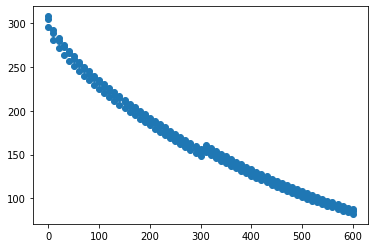

In [216]:
plt.scatter(model.calc_data_all['T'],model.calc_data_all['Delta_sigma_ss'])

In [217]:
from scipy import stats

In [244]:
# import ss_edge_model as ss_edge_model
from scipy import stats 

class ss_edge_model_T_w_uncertainty:
# calculate solid solution strengthening contribution for FCC/BCC CCAs
# different from ss_edge_model, 
# consider the uncertainties in the elemental data input, lattice constants and elastic constants
# Edge dislocation models
# FCC model: Varvenne-Leyson-Ghazisaeidi-Curtin 2016: http://dx.doi.org/10.1016/j.actamat.2016.09.046
# BCC model: Maresca-Curtin 2020: 
    def __init__(self,
                 ss_edge_model_T,
                 adjustable_scaler,
                 exp_conditions,
                 comp_elements,
                 elements_data,
                 uncertainty_levels,
                 structure):
        

        self.adjustable_scaler = adjustable_scaler
        self.exp_conditions = exp_conditions
        self.T_range = np.array(exp_conditions[0])
        self.compositions_all = comp_elements
        self.elements_order = comp_elements.columns.tolist()
        self.elements_data_save = copy.deepcopy(elements_data)
        self.structure = structure 
        self.J2eV=6.2415093433*10**18 # covert J to eV
        self.elements_data = elements_data

        # uncertainty_levels controls the distribution of random variables of inputs
        # uncertainty_levels[0] for lattice constant a
        # uncertainty_levels[1] for elastic constants E, G, nu
        # use normal distribution
        # so uncertainty level is converted to standard deviation 
        # then the uncertainty will propagate to the predicted quantities. 
        # predicted quantity uncertainty will be appended to the predicted data. 
        
        self.uncertainty_levels = uncertainty_levels 
        
    def gen_rv(self):

        new_elements_data = copy.deepcopy(self.elements_data_save)
        if self.structure == 'fcc':
            for element_i in self.elements_order:
                new_elements_data[element_i]['a']  = stats.norm.rvs( self.elements_data_save[element_i]['a'],scale=self.elements_data_save[element_i]['a']*self.uncertainty_levels[0])
                new_elements_data[element_i]['b']  = new_elements_data[element_i]['a']*np.sqrt(2)/2
                new_elements_data[element_i]['Vn'] = new_elements_data[element_i]['a']**3/4
                new_elements_data[element_i]['E']  = stats.norm.rvs( self.elements_data_save[element_i]['E'],scale=self.elements_data_save[element_i]['E']*self.uncertainty_levels[1])
                new_elements_data[element_i]['G']  = stats.norm.rvs( self.elements_data_save[element_i]['G'],scale=self.elements_data_save[element_i]['G']*self.uncertainty_levels[1])
                new_elements_data[element_i]['nu']  = stats.norm.rvs( self.elements_data_save[element_i]['nu'],scale=self.elements_data_save[element_i]['nu']*self.uncertainty_levels[1])
        else:
            for element_i in self.elements_order:
                new_elements_data[element_i]['a']  = stats.norm.rvs( self.elements_data_save[element_i]['a'],scale=self.elements_data_save[element_i]['a']*self.uncertainty_levels[0])
                new_elements_data[element_i]['b']  = new_elements_data[element_i]['a']*np.sqrt(3)/2
                new_elements_data[element_i]['Vn'] = new_elements_data[element_i]['a']**3/2
                new_elements_data[element_i]['E']  = stats.norm.rvs( self.elements_data_save[element_i]['E'],scale=self.elements_data_save[element_i]['E']*self.uncertainty_levels[1])
                new_elements_data[element_i]['G']  = stats.norm.rvs( self.elements_data_save[element_i]['G'],scale=self.elements_data_save[element_i]['G']*self.uncertainty_levels[1])
                new_elements_data[element_i]['nu']  = stats.norm.rvs( self.elements_data_save[element_i]['nu'],scale=self.elements_data_save[element_i]['nu']*self.uncertainty_levels[1])
        return new_elements_data

    def calculate(self):
        

        self.model = ss_edge_model_T(self.adjustable_scaler,
                           self.exp_conditions,
                           self.compositions_all,
                           self.elements_data,
                           self.structure
                          )
        calc_header = ['T','V_ave','b_ave','E_ave','G_ave','nu_ave','sum_cnVn^2_b6','Ty0','Delta_Eb','tau_y','Delta_sigma_ss',
                       'std_V_ave','std_b_ave','std_E_ave','std_G_ave','std_nu_ave','std_sum_cnVn','std_Ty0','std_Delta_Eb',
                      'std_tau_y','std_Delta_sigma_ss']
        element_header = self.compositions_all.columns.to_list()
        calc_data_all = pd.DataFrame(columns=element_header+calc_header)
        for composition_idx in range(len(self.compositions_all)):
            self.model.compositions = self.compositions_all.iloc[composition_idx]
               # print(self.compositions)
            for T in self.T_range:
                self.model.T = T
                self.aver_V_list = []
                self.aver_b_list = []
                self.aver_E_list = []
                self.aver_G_list = []
                self.aver_Nu_list = []
                self.sum_cndVn_b6_list = []
                self.Ty0_list = []
                self.dEb_list = []
                self.delta_ss_list = []
                i=0
                self.model.change_element_data(copy.deepcopy(self.elements_data_save))
                #print(self.model.elements_data)
                if self.structure == 'fcc':
                    self.model.FCC_V_L_G_C_2016_analytical()
                elif self.structure == 'bcc':
                    self.model.BCC_M_C_2020_analytical()
                        
                self.aver_V = self.model.aver_V 
                self.aver_b = self.model.aver_b
                self.aver_E = self.model.aver_E 
                self.aver_G = self.model.aver_G 
                self.aver_Nu = self.model.aver_Nu
                self.aver_sum_cndVn_b6 = self.model.sum_cndVn_b6 
                self.aver_Ty0 = self.model.Ty0
                self.aver_dEb = self.model.dEb
                #self.aver_tau_y = self.model.tau_y 
                self.aver_delta_ss = self.model.delta_ss 
                
                while i <=200:

                    #self.elements_data = self.gen_rv()
                    self.model.change_element_data(self.gen_rv())
                    if self.structure == 'fcc':
                        self.model.FCC_V_L_G_C_2016_analytical()
                    elif self.structure == 'bcc':
                        self.model.BCC_M_C_2020_analytical()

                    self.aver_V_list.append(self.model.aver_V)
                    self.aver_b_list.append(self.model.aver_b)
                    self.aver_E_list.append(self.model.aver_E)
                    self.aver_G_list.append(self.model.aver_G)
                    self.aver_Nu_list.append(self.model.aver_Nu)
                    self.sum_cndVn_b6_list.append(self.model.sum_cndVn_b6)
                    self.Ty0_list.append(self.model.Ty0)
                    self.dEb_list.append(self.model.dEb)
                    self.delta_ss_list.append(self.model.delta_ss)
                    i+=1

                ''' or you can take the average 
                self.aver_V = np.mean( np.array([ aver_V for aver_V in self.aver_V_list ]), axis=0 )
                self.aver_b = np.mean( np.array([ aver_b for aver_b in self.aver_b_list ]), axis=0 )
                self.aver_E = np.mean( np.array([ aver_E for aver_E in self.aver_E_list ]), axis=0 )
                self.aver_G = np.mean( np.array([ aver_G for aver_G in self.aver_G_list ]), axis=0 )
                self.aver_Nu = np.mean( np.array([ aver_Nu for aver_Nu in self.aver_Nu_list ]), axis=0 )
                self.aver_sum_cndVn_b6 = np.mean( np.array([ sum_cndVn_b6 for sum_cndVn_b6 in self.sum_cndVn_b6_list ]), axis=0 )
                self.aver_Ty0 = np.mean( np.array([ Ty0 for Ty0 in self.Ty0_list ]), axis=0 )
                self.aver_dEb = np.mean( np.array([ dEb for dEb in self.dEb_list ]), axis=0 )
                self.aver_delta_ss = np.mean( np.array([delta_ss for delta_ss in self.delta_ss_list ]), axis=0 )'''

                self.std_V = np.std( np.array([ aver_V for aver_V in self.aver_V_list ]), axis=0 )
                self.std_b = np.std( np.array([ aver_b for aver_b in self.aver_b_list ]), axis=0 )
                self.std_E = np.std( np.array([ aver_E for aver_E in self.aver_E_list ]), axis=0 )
                self.std_G = np.std( np.array([ aver_G for aver_G in self.aver_G_list ]), axis=0 )
                self.std_Nu = np.std( np.array([ aver_Nu for aver_Nu in self.aver_Nu_list ]), axis=0 )
                self.std_sum_cndVn_b6 = np.std( np.array([ sum_cndVn_b6 for sum_cndVn_b6 in self.sum_cndVn_b6_list ]), axis=0 )
                self.std_Ty0 = np.std( np.array([ Ty0 for Ty0 in self.Ty0_list ]), axis=0 )
                self.std_dEb = np.std( np.array([ dEb for dEb in self.dEb_list ]), axis=0 )
                self.std_delta_ss = np.std( np.array([ delta_ss for delta_ss in self.delta_ss_list ]), axis=0 )
                
                
                calc_values = [T,
                               np.round(self.aver_V*10**30,2),
                               np.round(self.aver_b*10**10,4),
                               np.round( self.aver_E/10**9,2),
                               np.round( self.aver_G/10**9,2),
                               np.round( self.aver_Nu,4),
                               np.round(self.aver_sum_cndVn_b6,8),
                               np.round(self.aver_Ty0/10**6,2),
                               np.round(self.aver_dEb*self.J2eV,4),
                               np.round(self.aver_delta_ss/10**6/self.model.Taylor_fac,2),
                               np.round(self.aver_delta_ss/10**6,2),
                               
                               np.round(self.std_V*10**30,2),
                               np.round(self.std_b*10**10,4),
                               np.round( self.std_E/10**9,2),
                               np.round( self.std_G/10**9,2),
                               np.round( self.std_Nu,4),
                               np.round(self.std_sum_cndVn_b6,8),
                               np.round(self.std_Ty0/10**6,2),
                               np.round(self.std_dEb*self.J2eV,4),
                               np.round(self.std_delta_ss/10**6/self.model.Taylor_fac,2),
                               np.round(self.std_delta_ss/10**6,2),
                               ]
                #print(calc_values)
                to_append = {**dict(zip(element_header,self.model.compositions.values)),**dict(zip(calc_header,calc_values))}
                #print(to_append)
                calc_data_all = calc_data_all.append(to_append,ignore_index=True)
        self.calc_data_all = calc_data_all
    def writedata(self,foutname):
        outputfile = foutname 
        self.calc_data_all.to_csv(outputfile,index=False,sep='\t',float_format='%.2f')
        print('-------------------------------Data Saved to {}-------------------------------'.format(outputfile))



In [245]:
input_data.element_data

{'Co': {'Vn': 11.12,
  'E': 262.9,
  'G': 101.7,
  'nu': 0.292,
  'a': 3.5431395642259846,
  'b': 2.5053780125545426},
 'Ni': {'Vn': 10.94,
  'E': 199.1,
  'G': 76.0,
  'nu': 0.309,
  'a': 3.523917814103424,
  'b': 2.4917861826966066},
 'Mn': {'Vn': 12.6,
  'E': 197.7,
  'G': 73.4,
  'nu': 0.347,
  'a': 3.6938295008956663,
  'b': 2.6119318886302456},
 'Fe': {'Vn': 12.09,
  'E': 194.3,
  'G': 73.4,
  'nu': 0.324,
  'a': 3.643304168792106,
  'b': 2.576205083678116}}

In [246]:
model_mc = ss_edge_model_T_w_uncertainty(
                 ss_edge_model_T,
                 input_data.adjustable_scaler,
                 input_data.exp_conditions,
                 input_data.element_composition,
                 input_data.element_data,
                 input_data.uncertainty_levels,
                 input_data.structure)

In [247]:
model_mc.structure

'fcc'

In [248]:
model_mc.calculate()

In [249]:
model_mc.calc_data_all

,Co,Ni,Fe,Mn,T,V_ave,b_ave,E_ave,G_ave,nu_ave,...,std_V_ave,std_b_ave,std_E_ave,std_G_ave,std_nu_ave,std_sum_cnVn,std_Ty0,std_Delta_Eb,std_tau_y,std_Delta_sigma_ss
0,25.0,25.0,25.0,25.0,0.0,11.69,2.5463,213.5,81.12,0.3180,...,0.17,0.0124,4.73,2.04,0.0070,0.001020,37.48,0.2228,37.48,114.68
1,25.0,25.0,25.0,25.0,10.0,11.69,2.5463,213.5,81.12,0.3180,...,0.19,0.0141,5.55,2.11,0.0077,0.000872,32.72,0.1949,31.65,96.84
2,25.0,25.0,25.0,25.0,20.0,11.69,2.5463,213.5,81.12,0.3180,...,0.19,0.0135,5.16,2.06,0.0082,0.000910,33.64,0.2022,31.85,97.47
3,25.0,25.0,25.0,25.0,30.0,11.69,2.5463,213.5,81.12,0.3180,...,0.19,0.0141,5.28,1.99,0.0075,0.000982,36.36,0.2185,33.84,103.54
4,25.0,25.0,25.0,25.0,40.0,11.69,2.5463,213.5,81.12,0.3180,...,0.17,0.0126,4.99,1.95,0.0074,0.000881,32.88,0.1945,30.15,92.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,30.0,30.0,20.0,20.0,560.0,11.56,2.5368,217.0,82.67,0.3145,...,0.16,0.0121,5.44,2.01,0.0087,0.000890,33.12,0.1921,16.89,51.69
179,30.0,30.0,20.0,20.0,570.0,11.56,2.5368,217.0,82.67,0.3145,...,0.18,0.0134,5.43,2.07,0.0077,0.000864,33.26,0.1983,16.24,49.69
180,30.0,30.0,20.0,20.0,580.0,11.56,2.5368,217.0,82.67,0.3145,...,0.17,0.0125,5.72,2.02,0.0070,0.000934,34.78,0.2011,17.12,52.38
181,30.0,30.0,20.0,20.0,590.0,11.56,2.5368,217.0,82.67,0.3145,...,0.17,0.0127,5.67,2.24,0.0081,0.000975,36.18,0.2137,17.43,53.35


In [250]:
mask=(model_mc.calc_data_all['Co']==model_mc.calc_data_all['Ni'])&(model_mc.calc_data_all['Co']==25)
model_mc.calc_data_all[mask]

,Co,Ni,Fe,Mn,T,V_ave,b_ave,E_ave,G_ave,nu_ave,...,std_V_ave,std_b_ave,std_E_ave,std_G_ave,std_nu_ave,std_sum_cnVn,std_Ty0,std_Delta_Eb,std_tau_y,std_Delta_sigma_ss
0,25.0,25.0,25.0,25.0,0.0,11.69,2.5463,213.5,81.12,0.318,...,0.17,0.0124,4.73,2.04,0.0070,0.001020,37.48,0.2228,37.48,114.68
1,25.0,25.0,25.0,25.0,10.0,11.69,2.5463,213.5,81.12,0.318,...,0.19,0.0141,5.55,2.11,0.0077,0.000872,32.72,0.1949,31.65,96.84
2,25.0,25.0,25.0,25.0,20.0,11.69,2.5463,213.5,81.12,0.318,...,0.19,0.0135,5.16,2.06,0.0082,0.000910,33.64,0.2022,31.85,97.47
3,25.0,25.0,25.0,25.0,30.0,11.69,2.5463,213.5,81.12,0.318,...,0.19,0.0141,5.28,1.99,0.0075,0.000982,36.36,0.2185,33.84,103.54
4,25.0,25.0,25.0,25.0,40.0,11.69,2.5463,213.5,81.12,0.318,...,0.17,0.0126,4.99,1.95,0.0074,0.000881,32.88,0.1945,30.15,92.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,25.0,25.0,25.0,25.0,560.0,11.69,2.5463,213.5,81.12,0.318,...,0.16,0.0118,5.18,2.03,0.0080,0.001015,36.80,0.2151,19.00,58.13
57,25.0,25.0,25.0,25.0,570.0,11.69,2.5463,213.5,81.12,0.318,...,0.18,0.0129,5.06,2.03,0.0077,0.000831,31.18,0.1889,15.67,47.94
58,25.0,25.0,25.0,25.0,580.0,11.69,2.5463,213.5,81.12,0.318,...,0.19,0.0136,5.01,2.03,0.0071,0.000926,34.96,0.2149,16.92,51.78
59,25.0,25.0,25.0,25.0,590.0,11.69,2.5463,213.5,81.12,0.318,...,0.19,0.0136,5.14,1.93,0.0084,0.000970,35.16,0.2046,17.32,52.99


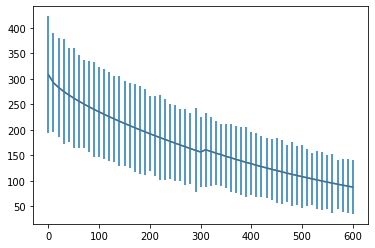

In [251]:
plt.errorbar(((model_mc.calc_data_all[mask]['T'])),
             model_mc.calc_data_all[mask]['Delta_sigma_ss'],
             yerr=model_mc.calc_data_all[mask]['std_Delta_sigma_ss'])

plt.plot(((model.calc_data_all[mask]['T'])),
             model.calc_data_all[mask]['Delta_sigma_ss'])



In [228]:
[model.delta_ss,model_mc.model.]

[86135722.4612805, 130590441.07441373]

In [565]:
np.std( np.array([ model.delta_ss, model_mc.model.delta_ss ]), axis=0 )/1000000

array([ 0.        ,  3.06541655,  6.526864  , ..., 12.81950042,
        1.38419873,  0.57720542])

In [50]:
model_mc.calc

NameError: name 'model_mc' is not defined